The goal of this notebook is to create a student-teacher model where we first train a teacher on labeled data, and then use this teacher model to label more data, then we swap out the teacher with a student and train again over all the samples. 
- Add data augmentation
- Add dropout and regularization
- Resample the dataset (also the one created from unlab_ds)

# Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, show_image, prepare_for_training
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henrik/master-thesis/data/hyper-kvasir/labeled/')

config = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'hyp-kva-aug-drop',
    "augment": True,
    "resample": False,
    "shuffle_buffer_size": 1000,       # 0=no shuffling
    "seed": 124,
    "neg_class": None,                 # select neg class for binary ds
    "outcast": None,                   # list of folders to drop
    # Model
    "model": 'EfficientNetB0',
    "num_epochs": 60,
    "batch_size": 128,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": True,
    "checkpoint": False,
    "early_stopping": False,
    "early_stopping_patience": 15,
    "decay_rate": 0.05,                # higher number gives steeper dropoff
    # Misc
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]

barretts-short-segment      :   53 | 0.50%
bbps-0-1                    :  646 | 6.06%
impacted-stool              :  131 | 1.23%
bbps-2-3                    : 1148 | 10.77%
hemorrhoids                 :    6 | 0.06%
ulcerative-colitis-grade-2  :  443 | 4.15%
normal-z-line               :  932 | 8.74%
retroflex-stomach           :  764 | 7.17%
esophagitis-b-d             :  260 | 2.44%
dyed-resection-margins      :  989 | 9.28%
ileum                       :    9 | 0.08%
ulcerative-colitis-0-1      :   35 | 0.33%
dyed-lifted-polyps          : 1002 | 9.40%
polyps                      : 1028 | 9.64%
ulcerative-colitis-2-3      :   28 | 0.26%
ulcerative-colitis-1-2      :   11 | 0.10%
ulcerative-colitis-grade-3  :  133 | 1.25%
retroflex-rectum            :  391 | 3.67%
esophagitis-a               :  403 | 3.78%
ulcerative-colitis-grade-1  :  201 | 1.89%
pylorus                     :  999 | 9.37%
cecum                       : 1009 | 9.46%
barretts                    :   41 | 0.38%

Total num

# Step 1: Train a teacher model on labeled images

In [4]:
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers

### Create and compile the model

In [5]:
if config["model"] == 'EfficientNetB0': 
    from efficientnet import EfficientNetB0 as EfficientNet # 5.3M params
elif config["model"] == 'EfficientNetB1': 
    from efficientnet import EfficientNetB1 as EfficientNet # 7.8M params
elif config["model"] = 'EfficientNetB2':
    from efficientnet import EfficientNetB2 as EfficientNet # 9.2M params
elif config["model"] = 'EfficientNetB3':
    from efficientnet import EfficientNetB3 as EfficientNet # 12M params

Using TensorFlow backend.


In [6]:
efficientnet_base = EfficientNet(
    weights="imagenet",
    include_top=False, 
    input_shape=config["img_shape"]
)

In [7]:
# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True

# Define model
en_model = Sequential()
en_model.add(efficientnet_base)
en_model.add(layers.GlobalAveragePooling2D())
en_model.add(layers.Dropout(0.3))
en_model.add(layers.Dense(512, activation='relu'))
en_model.add(layers.Dropout(0.3))
en_model.add(layers.Dense(params["num_classes"], activation=config["final_activation"]))

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

en_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [8]:
en_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 4,717,235
Trainable params: 4,675,219
Non-trainable params: 42,016
_________________________________________

### Callbacks

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

In [10]:
# By using LearnignRateScheduler
initial_learning_rate = config["learning_rate"]
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss', 
                              verbose=1, patience=config["early_stopping_patience"], 
                              restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', 
                                monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if config["early_stopping"]: callbacks.append(earlystopp_cb)
if config["learning_schedule"]: callbacks.append(lr_schedule_cb)
if config["checkpoint"]: callbacks.append(checkpoint_cb)

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write(str(config))
f.close()

# Write params dictionary to text file
f = open(log_dir+"/params.txt","w")
f.write(str(params))
f.close()

### Train the teacher model

In [11]:
history = en_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/60
58/58 [==============================] - 21s 361ms/step - loss: 1.5073 - sparse_categorical_accuracy: 0.5691 - val_loss: 3919.4466 - val_sparse_categorical_accuracy: 0.0579

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009006211180124225.
Epoch 2/60
58/58 [==============================] - 14s 250ms/step - loss: 0.7791 - sparse_categorical_accuracy: 0.7470 - val_loss: 11.6521 - val_sparse_categorical_accuracy: 0.0853

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008192090395480226.
Epoch 3/60
58/58 [==============================] - 14s 247ms/step - loss: 0.6250 - sparse_categorical_accuracy: 0.7909 - val_loss: 4.3603 - val_sparse_categorical_accuracy: 0.3796

Epoch 00004: LearningRateScheduler reducing learning rate to 0.007512953367875648.
Epoch 4/60
58/58 [==============================] - 14s 246ms/step - loss: 0.5121 - sparse_

In [12]:
# Save the metrics from training
f = open(log_dir+"/history.txt","w")
f.write(str(history.history))
f.close()

Save or restore a model

## Evaluate the model

In [13]:
# Check if validation data is cached
cache_dir = config["cache_dir"]
img_width = config["img_shape"][0]
ds_info = config["ds_info"]
filename = "{}/{}_{}_val.tfcache.index".format(cache_dir, img_width, ds_info)

cached = os.path.isfile(filename)
if not cached:
    # Iterate over dataset to initialize caching
    for batch in val_ds.take(params["val_size"]):
        pass

In [14]:
en_evaluate = en_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/val_evaluate.txt","w")
f.write( str(en_evaluate) )
f.close()

12/12 - 1s - loss: 0.8284 - sparse_categorical_accuracy: 0.8743


In [15]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

if config["learning_schedule"]: lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

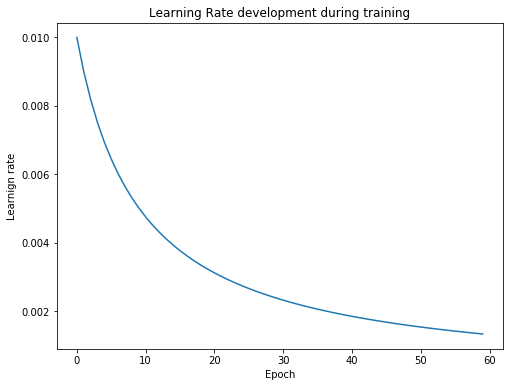

In [16]:
if config["learning_schedule"]:
    # Plot the learning rate
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, lr, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learnign rate')
    plt.title('Learning Rate development during training');
    plt.savefig(log_dir+'/learning_rate.pdf', format='pdf')

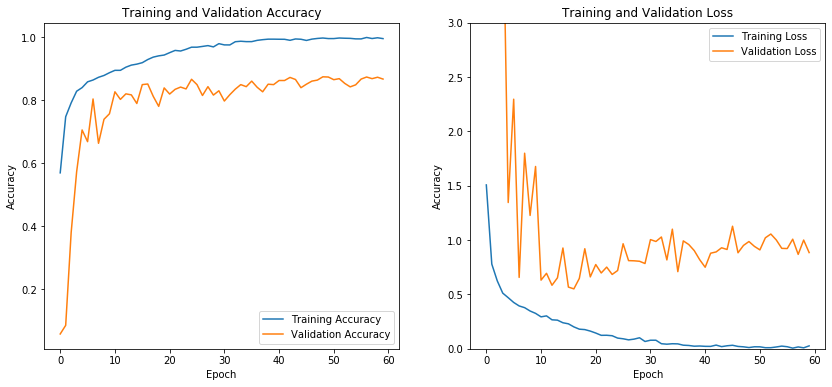

In [17]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.pdf', format='pdf')
plt.show()

### Test: run prediction on images from the validation dataset

### Test: run prediction on images from the unlabeled_test dataset
(which are images taken from the training data)  
TODO: just remove this?

# Step 2: use the teacher to generate pseudo labels on unlabeled images

### Read in the unlabeled dataset

In [18]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [config["img_shape"][0], config["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled = pathlib.Path('/home/henrik/master-thesis/data/hyper-kvasir/unlabeled/')

ds_size_unlabeled = len(list(data_dir_unlabeled.glob('*.*g')))

files_string = str(data_dir_unlabeled/'*.*g')
list_ds_unlabeled = tf.data.Dataset.list_files(
        files_string, 
        shuffle=config["shuffle_buffer_size"]>1, 
        seed=tf.constant(config["seed"], tf.int64)
)

unlabeled_ds = list_ds_unlabeled.map(process_path, num_parallel_calls=AUTOTUNE)

print ("Loaded {} images into unlabeled_ds.".format(ds_size_unlabeled))

Loaded 99417 images into unlabeled_ds.


File: aacdc763-c0cd-4fc0-952c-89828c76b539.jpg

16.02% ulcerative-colitis-grade-2
11.08% ileum
 5.76% polyps
58.30% pylorus
 6.46% cecum


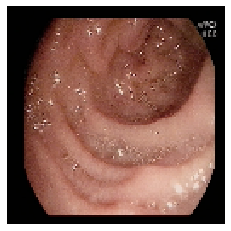

In [49]:
# Run prediction on 1 image
#img, name = next(iter(unlabeled_ds))

for img, name in unlabeled_ds.take(1):

    print ("File:",str(name.numpy())[2:-1], end='\n\n')
    show_image(img.numpy())

    # Add dimension and predict
    img = np.expand_dims(img.numpy(), 0)
    prediction = en_model.predict(img, verbose=0)

    # If probability above 1% print info
    for i, pred in enumerate(prediction[0]):
         if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

### Run predictions on all unlabeled images
Using 'append to list and convert to tensor'-method
- caching the dataset takes too much space

In [55]:
from tqdm.notebook import tqdm

pred_confidence = 0.80
new_samples_counter = 0
count = 0
img_list = []
lab_list = []

In [58]:
total_time = time.time()

tqdm_predicting = tqdm(total=ds_size_unlabeled, desc='Predicting', position=0, initial=count)
tqdm_findings = tqdm(total=ds_size_unlabeled, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_samples_counter)

print ("Press 'Interrupt Kernel' to save and exit.")
try:
    for count, (image,label) in enumerate(unlabeled_ds, start=count):
        img = np.expand_dims(image, 0)
        pred = en_model.predict(img)
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)
            #pred_class = class_names[pred_idx]

            img_list.append(image)
            lab_list.append(pred_idx)
            # pred_list.append(highest_pred)
            
            new_samples_counter += 1
            tqdm_findings.update(1)
        tqdm_predicting.update(1)
except KeyboardInterrupt:
    print ("Exiting")

finally:
    print ("\nTotal run time: {:.3f} s".format( time.time() - total_time ))
    print ("Found {} new samples in unlabeled_ds after looking at {} images.".format(new_samples_counter, count))

Press 'Interrupt Kernel' to save and exit.

Total run time: 2664.778 s
Found 83346 new samples in unlabeled_ds after looking at 103102 images.


Save the image and labels list as pickle dump

### Make bar chart of findings from unlabeled dataset

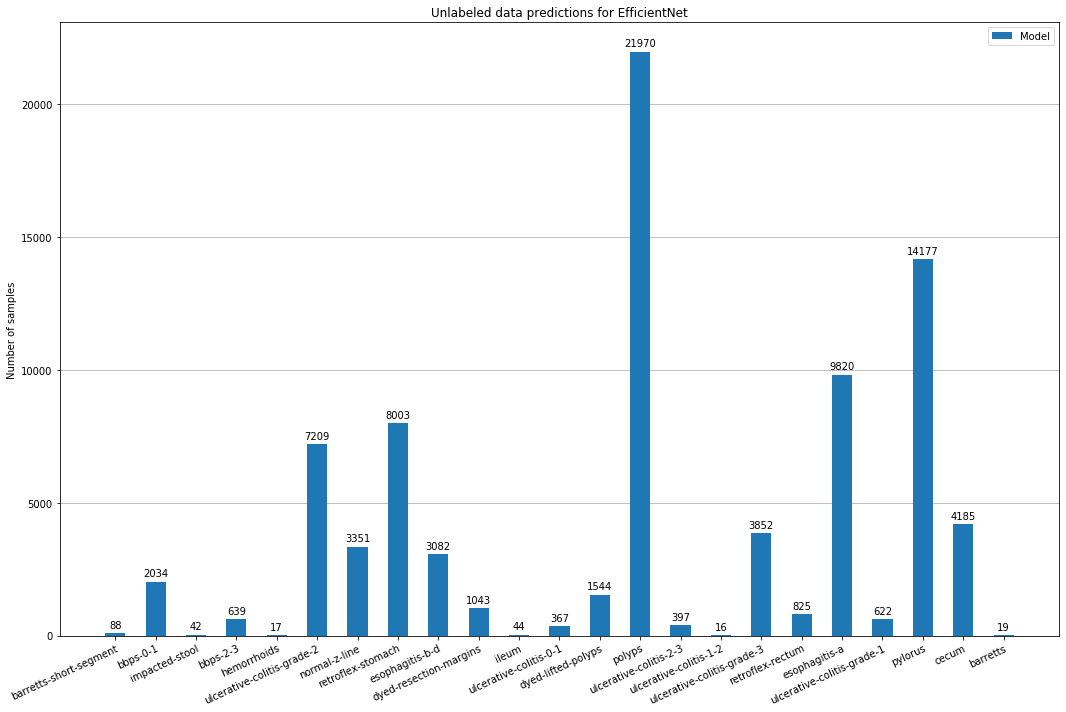

In [59]:
# Count findings
findings = np.asarray([(i, lab_list.count(i)) for i in range(params["num_classes"])])

assert len(class_names) == len(findings), "Must be same length."

x = findings[:,0]
width = 0.5

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x, findings[:,1], width, label='Model')
#rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of samples')
ax.set_title('Unlabeled data predictions for EfficientNet')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_axisbelow(True)
ax.legend()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
         rotation_mode="anchor")
plt.grid(axis='y')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()
plt.savefig(log_dir+'/unlab_data_prediction.pdf', format='pdf')
plt.show()

Inspect the classified images

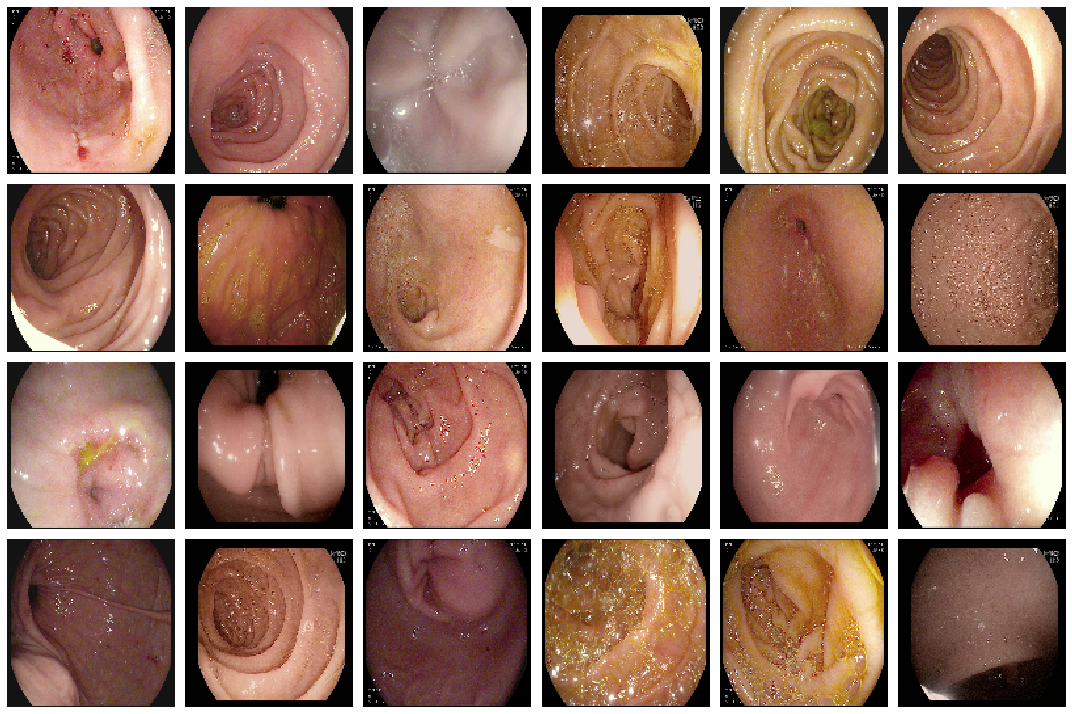

In [64]:
# The class we want to show images from
checkout = 'pylorus'
# Which class number correspond to that class name
idx = np.where(class_names == checkout)[0][0]
# List of img_list-indexes with images corresponding to that class number
idx_list = np.where(lab_list == idx)[0]

# settings
nrows, ncols = 4, 6  # array of sub-plots
figsize = [15, 10]     # figure size, inches


# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=figsize, frameon=False, facecolor='white')

# plot simple raster image on each sub-plot
try:
    for i, axi in enumerate(ax.flat):
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        img = img_list[idx_list[i]]
        axi.imshow(img)
        # get indices of row/column
        rowid = i // ncols
        colid = i % ncols
        # write row/col indices as axes' title for identification
        #axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))
        axi.set_axis_off()
except IndexError:
    pass

plt.axis('off')
plt.tight_layout(True)
plt.savefig("{}/unlab_data_checkout-{}.pdf".format(log_dir, checkout), format='pdf')
plt.show()

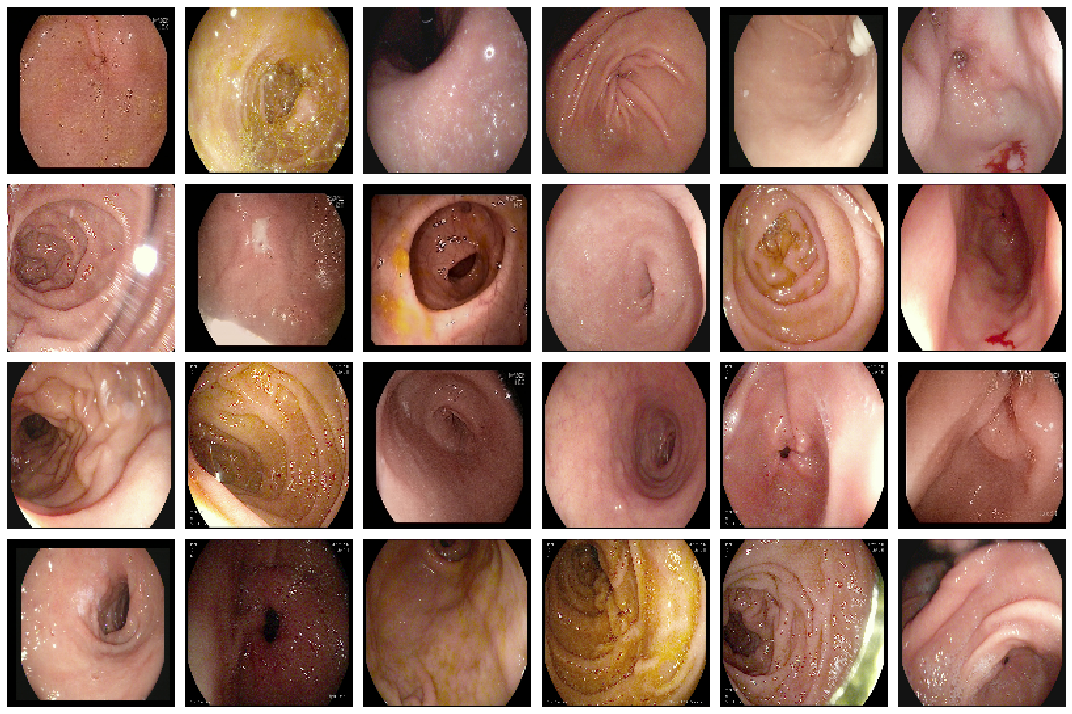

In [31]:
# The class we want to show images from
checkout = 'pylorus'
# Which class number correspond to that class name
idx = np.where(class_names == checkout)[0][0]
# List of img_list-indexes with images corresponding to that class number
idx_list = np.where(lab_list == idx)[0]

# This should be a function

# settings
nrows, ncols = 4, 6  # array of sub-plots
figsize = [15, 10]     # figure size, inches


# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=figsize, frameon=False, facecolor='white')

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = img_list[idx_list[i]]
    axi.imshow(img)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    #axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))
    axi.set_axis_off()

plt.axis('off')
plt.tight_layout(True)
plt.savefig("{}/unlab_data_checkout-{}.pdf".format(log_dir, checkout), format='pdf')
plt.show()

### Convert image and label lists to tensors and combine with training_ds to create a new dataset

In [ ]:
findings_tensor = tf.data.Dataset.from_tensor_slices((img_list, lab_list))

In [ ]:
# combine with old ds
combined_ds = train_ds.unbatch().take(params["train_size"]).concatenate(findings_tensor)

# Step 3: Train a student model on the combination of labeled images and pseudo labeled images

Now we have trained a teacher model, and used that model to predict on unlabeled dataset to create more samples with psudo-labels.  
It's time for swapping the teacher with the student!

In [ ]:
combined_ds = prepare_for_training(
        combined_ds, 
        config["batch_size"], 
        cache=None,
        shuffle_buffer_size=0
    )

In [ ]:
# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True

# Define model
stud_model = Sequential()
stud_model.add(efficientnet_base)
stud_model.add(layers.GlobalAveragePooling2D())
# en_model.add(layers.Dropout(0.2))
# en_model.add(layers.Dense(256, activation='relu'))
stud_model.add(layers.Dense(params["num_classes"], activation=config["final_activation"]))

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

stud_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
train_steps = params["train_size"]+new_samples_counter // config["batch_size"]

In [ ]:
history = stud_model.fit(
    combined_ds,
    steps_per_epoch = train_steps, # might have to reduce
    epochs = 2,
    validation_data = test_ds, # what to use for validation data?
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

# Step 4: Iterate this algorithm a few times by treating the student as a teacher to relabel the unlabeled data and training a new student